In [1]:
%config Completer.use_jedi = False # use autocompletion

import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

## Fix issues with livecell annotations

In [9]:
# annDir=Path('sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell')
# types = ['train', 'test', 'val']

# for t in types:
#     p = annDir/f'livecell_coco_{t}.json'
#     with open(p, "r") as f:
#         j = json.load(f)
#     j['annotations'] = list(j["annotations"].values())
#     with open(p, 'w+') as json_file:
#         json.dump(j, json_file)

## Training


### Load the competition data

In [2]:
dataDir=Path('sartorius-cell-instance-segmentation')

register_coco_instances('sartorius_train',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)

register_coco_instances('sartorius_train_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json', dataDir)
register_coco_instances('sartorius_val_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json', dataDir)
register_coco_instances('sartorius_test_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json', dataDir)

metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
val_ds = DatasetCatalog.get('sartorius_val')

metadata_live = MetadataCatalog.get('sartorius_train_live')
train_ds_live = DatasetCatalog.get('sartorius_train_live')
train_val_live = DatasetCatalog.get('sartorius_val_live')
train_test_live = DatasetCatalog.get('sartorius_test_live')

[12/02 13:32:48 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/02 13:32:49 d2.data.datasets.coco]: Loaded 122 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[12/02 13:32:59 d2.data.datasets.coco]: Loading sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json takes 10.73 seconds.
[12/02 13:33:00 d2.data.datasets.coco]: Loaded 3253 images in COCO format from sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json
[12/02 13:33:05 d2.data.datasets.coco]: Loading sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json takes 2.52 seconds.
[12/02 13:33:05 d2.data.datasets.coco]: Loaded 570 images in COCO format from sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
[12/02

### Display a sample file to check the data is loaded correctly

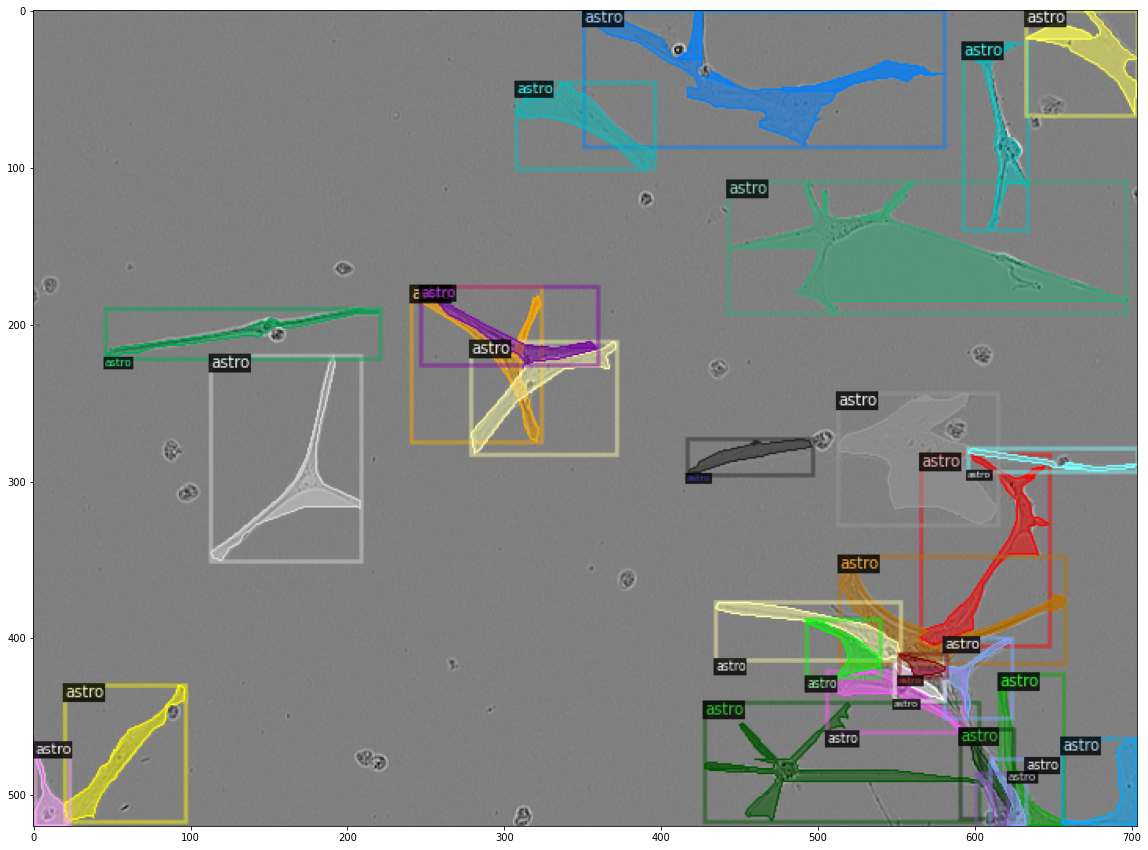

In [3]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define augmentation and evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

The dataset is transformed by changing the brighness and flipping the image with 50% probability...etc

In [32]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomSaturation(0.9, 1.1),
            T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks
    
    
class AugTrainer(Trainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 50 epochs

In [33]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train_a172",)
cfg.DATASETS.TEST = ("sartorius_val_a172",)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.DATALOADER.NUM_WORKERS = 2
    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.1 
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005


num_epochs = 50

cfg.SOLVER.WARMUP_ITERS = 10 # How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = num_epochs * len(DatasetCatalog.get('sartorius_train')) / cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.STEPS = []#(2000, 3000, 4000) # At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 250
#cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
# num of epochs is MAX_ITER * IMS_PER_BATCH / TOTAL_NUM_IMAGES = 7500 * 2 / 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg) # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[12/02 12:20:56 d2.data.datasets.coco]: Loaded 606 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/02 12:21:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size

TypeError: string indices must be integers

In [5]:
len(DatasetCatalog.get('sartorius_train'))

[12/02 09:31:47 d2.data.datasets.coco]: Loaded 606 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json


606

In [ ]:
50

In [6]:
cfg.SOLVER.MAX_ITER * cfg.SOLVER.IMS_PER_BATCH / len(DatasetCatalog.get('sartorius_train'))

[12/02 09:32:55 d2.data.datasets.coco]: Loaded 606 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json


24.752475247524753